In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Polygon, mapping
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.enums import Resampling
from rasterio.windows import Window
import earthpy as et
import earthpy.plot as ep

## Data Exploration

__Idea:__ Train a classifier on the pixels in the mask of the training data (if it exists?), then classify each pixel in the eval data as tree or not.

In [53]:
dtm_train_path = "../../data/raw_data/data/dtm_train.tif"
dsm_train_path = "../../data/raw_data/data/dsm_train.tif"
ortho_train_path = "../../data/raw_data/data/ortho_train.tif"
ortho_eval_path = "../../data/raw_data/eval_data/ortho_eval.tif"

In [20]:
with rio.open(dtm_train_path) as dtm:
    print(dtm.crs)

EPSG:32617


In [21]:
dtm.bounds

BoundingBox(left=274804.78000006, bottom=4603079.993190537, right=275062.7799999895, top=4603433.35924399)

In [22]:
dtm.res

(0.193403298298, 0.193413275015)

In [ ]:
with rio.open(lidar_dem_path) as src:
    # Convert / read the data into a numpy array
    # masked = True turns `nodata` values to nan
    lidar_dem_im = src.read(1, masked=True)
    
    # Create a spatial extent object using rio.plot.plotting
    spatial_extent = rio.plot.plotting_extent(src)

In [26]:
with rio.open(ortho_train_path) as ortho:
    print(ortho.meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 5160, 'height': 7068, 'count': 4, 'crs': CRS.from_epsg(32617), 'transform': Affine(0.0499999999864, 0.0, 274804.78000006,
       0.0, -0.0499951971494, 4603433.35924399)}


In [54]:
with rio.open(ortho_train_path) as ortho:
    ortho_data = ortho.read(masked = True)

In [31]:
with rio.open(ortho_train_path) as ortho:
    ortho_masks = ortho.read_masks()

In [41]:
with rio.open(ortho_eval_path) as ortho_eval:
    ortho_eval_masks = ortho_eval.read_masks()

Training data does not have a mask for trees already. Need to create one first.

List of things to do:
1. Check if all rasters are in same projection and have same dimensions
2. Make new mask for canopy height (CHM = DTM - DSM)
3. Check if CHM for trees and buildings can be distinguished (threshold for height?)
4. Calculate green chromatic coordinate (GCC = green/(green + red + blue)), maybe 0.33-0.4 will be trees
5. Make tree mask 
6. Train ML model (CNN? Decision trees?)

In [45]:
#Check raster project, dimensions, resolution
paths = [dsm_train_path, dtm_train_path, ortho_train_path, ortho_eval_path]

for each in paths:
    with rio.open(each) as src:
        print(src.crs, src.bounds, src.width, src.height, src.res)

EPSG:32617 BoundingBox(left=274804.78000006, bottom=4603079.993190537, right=275062.7799999895, top=4603433.35924399) 1334 1827 (0.193403298298, 0.193413275015)
EPSG:32617 BoundingBox(left=274804.78000006, bottom=4603079.993190537, right=275062.7799999895, top=4603433.35924399) 1334 1827 (0.193403298298, 0.193413275015)
EPSG:32617 BoundingBox(left=274804.78000006, bottom=4603079.993190538, right=275062.7799999898, top=4603433.35924399) 5160 7068 (0.0499999999864, 0.0499951971494)
EPSG:32617 BoundingBox(left=274804.78000006, bottom=4603079.993190538, right=275062.7799999898, top=4603433.35924399) 5160 7068 (0.0499999999864, 0.0499951971494)


DSM and DTM have lower resolution, but they cover the same area as the RGB. Need to upscale them to the RGB resolution. Will use a bilinear resampling method.

In [125]:
#Calculate CHM from DTM and DSM
with rio.open(dtm_train_path) as dtm:
    dtm_data = dtm.read(1, masked = True, out_shape = (7068, 5160), resampling = Resampling.bilinear)

with rio.open(dsm_train_path) as dsm:
    dsm_data = dsm.read(1, masked = True, out_shape = (7068, 5160), resampling = Resampling.bilinear)

chm = dsm_data - dtm_data

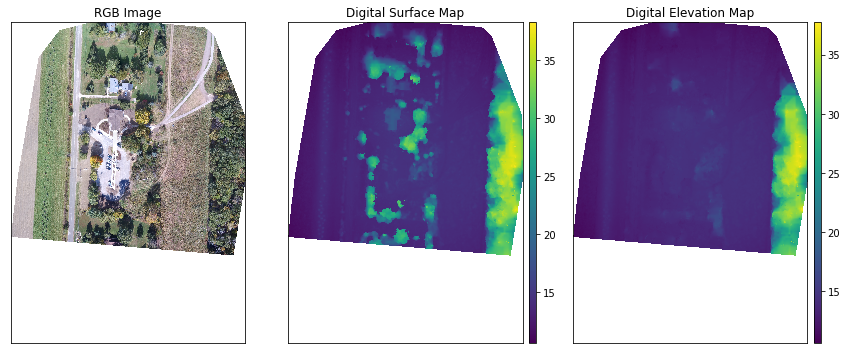

In [169]:
fig, ax = plt.subplots(1, 3, figsize = (12, 5))
ep.plot_rgb(ortho_data, ax = ax[0], title = "RGB Image")
ep.plot_bands(dsm_data, ax = ax[1], title = "Digital Surface Map", cmap = 'viridis', scale = False) #cbar = False)
ep.plot_bands(dtm_data, ax = ax[2], title = "Digital Elevation Map", cmap = 'viridis', scale = False) #cbar = False)
plt.tight_layout()
plt.savefig("../../reports/Figures/Fig1_rawimages.png", dpi = 300);

In [126]:
chm

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-9999.0,
  dtype=float32)

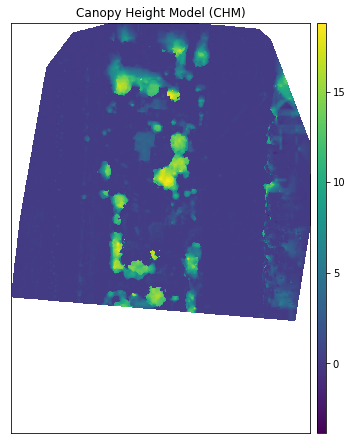

In [177]:
fig, ax = plt.subplots(figsize = (5, 8))
ep.plot_bands(chm, 
              cmap='viridis',
              title="Canopy Height Model (CHM)",
              ax = ax,
              scale=False)
plt.tight_layout()
plt.savefig("../../reports/Figures/Fig2_CHM.png", dpi = 300)

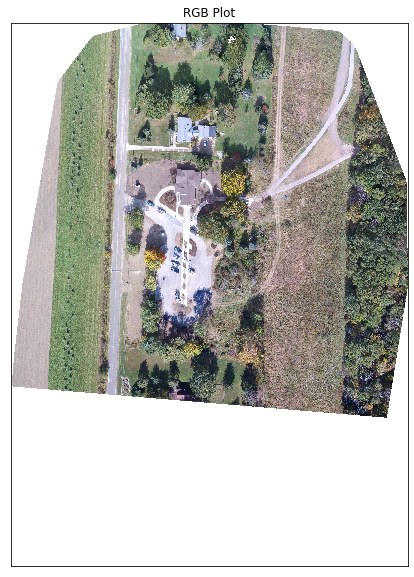

In [67]:
ep.plot_rgb(ortho_data, 
            title="RGB Plot")
plt.show()

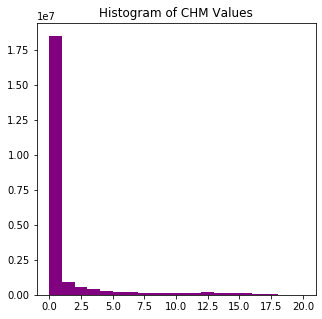

In [128]:
ep.hist(chm, 
        colors = 'purple',
        title="Histogram of CHM Values",
        hist_range=(0,20),
        figsize=(5, 5))
plt.show()

In [97]:
with rio.open(ortho_train_path) as src:
    print(src.colorinterp[3])

ColorInterp.alpha


In [113]:
#Calculate GCC from RGB data
gcc = ortho_data[1]/(ortho_data.sum(0))

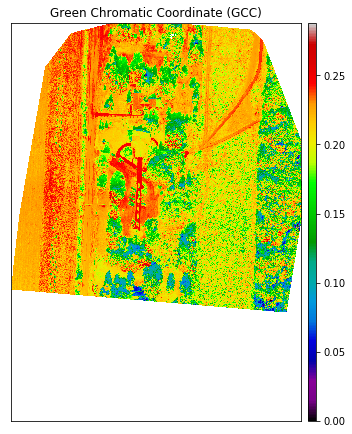

In [179]:
fig, ax = plt.subplots(figsize = (5, 8))
ep.plot_bands(gcc, 
              cmap='nipy_spectral',
              title="Green Chromatic Coordinate (GCC)",
              scale=False,
              ax = ax)
plt.tight_layout()
plt.savefig("../../reports/Figures/Fig3_GCC.png", dpi = 300)

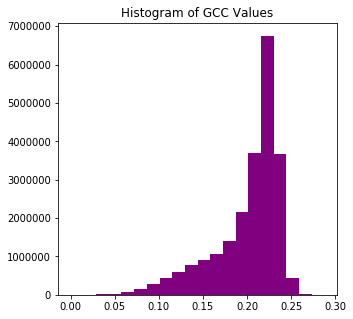

In [115]:
ep.hist(gcc, 
        colors = 'purple',
        title="Histogram of GCC Values",
        #hist_range=(0,20),
        figsize=(5, 5))
plt.show()

Seems like trees are generally >5m in height, but are easier to distinguish from buildings at around 10m. GCC is highly variable for trees, likely due to lighting conditions or phenology.  

In [192]:
chm.mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [51]:
import numpy.ma as ma

In [196]:
it = np.nditer(chm, flags = ['multi_index'])
mask = chm.copy() #np.zeros(chm.shape)
with it:
    while not it.finished:
        if it[0] >= 5: #and (gcc[it.multi_index] > 0.12 and gcc[it.multi_index] < 0.2):  
            mask[it.multi_index] = 255
        else:
            mask[it.multi_index] = 0
        it.iternext()
mask.mask = chm.mask

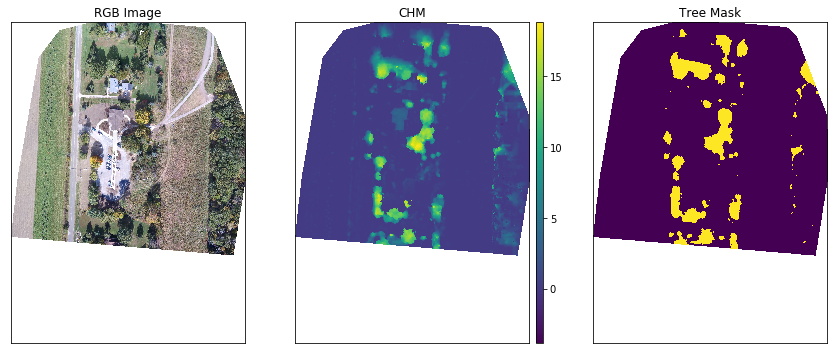

In [194]:
fig, ax = plt.subplots(1, 3, figsize = (12, 5))
ep.plot_rgb(ortho_data, ax = ax[0], title = "RGB Image")
ep.plot_bands(chm, ax = ax[1], title = "CHM", cmap = 'viridis', scale = False) #cbar = False)
ep.plot_bands(mask, ax = ax[2], title = "Tree Mask", cmap = 'viridis', scale = False, cbar = False)
plt.tight_layout()
plt.savefig("../../reports/Figures/Fig4_treemask.png", dpi = 300)

Just use canopy height as a way to mask the trees? Using GCC adds too much 'graininess' to the tree shapes. Or downsample using an averaging resample technique to smooth out the graininess?

In [62]:
with rio.open(ortho_train_path) as ortho:
    crs = ortho.crs
    transform = ortho.transform

In [222]:
with rio.open("../../data/data/tree_mask_train.tif", 
              'w',
              driver = 'GTiff',
              height = mask.shape[0],
              width = mask.shape[1],
              count = 1,
              dtype = mask.dtype,
              crs = crs,
              transform = transform) as tm:
    tm.write(mask, 1)

In [71]:
with rio.open("../../data/raw_data/data/tree_mask_train.tif") as trees:
    tmask = trees.read(1, masked = True)

In [249]:
with rio.open("../../data/data/tree_mask_train.tif") as trees:
    print(trees.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 5160, 'height': 7068, 'count': 1, 'crs': CRS.from_epsg(32617), 'transform': Affine(0.0499999999864, 0.0, 274804.78000006,
       0.0, -0.0499951971494, 4603433.35924399)}


In [250]:
with rio.open(ortho_train_path) as ortho:
    print(ortho.meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 5160, 'height': 7068, 'count': 4, 'crs': CRS.from_epsg(32617), 'transform': Affine(0.0499999999864, 0.0, 274804.78000006,
       0.0, -0.0499951971494, 4603433.35924399)}


Make training data:
- Randomly select windows from RGB and tree mask images, save to train/labels directories

In [258]:
with rio.open("../../data/data/tree_mask_train.tif") as tm:
    mask_win = tm.read(1, masked = True, window=Window(3000, 2000, 128, 128))

In [257]:
with rio.open(ortho_train_path) as src:
    win = src.read(window=Window(3000, 2000, 128, 128))

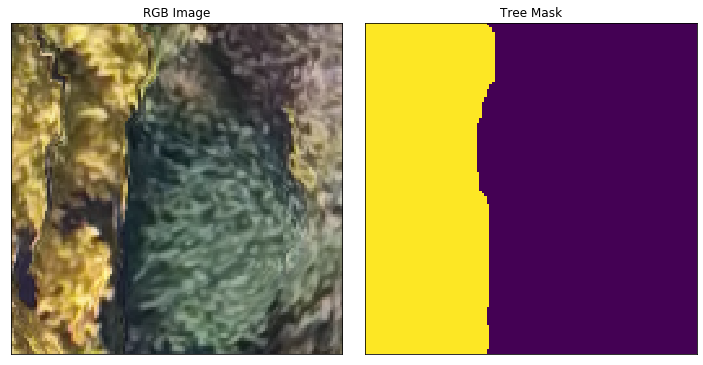

In [263]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ep.plot_rgb(win, ax = ax[0], title = "RGB Image")
ep.plot_bands(mask_win, ax = ax[1], cmap = 'viridis', scale = False, cbar = False, title="Tree Mask")
plt.tight_layout()
plt.savefig("../../reports/Figures/Fig5_window_sample.png", dpi = 300);

In [267]:
#Create training data from windows
with rio.open(ortho_train_path) as ortho:
    width = ortho.width
    height = ortho.height

for x in list(range(200, 1000)):
    col_off = np.random.choice(list(range(0, width - 128)))
    row_off = np.random.choice(list(range(0, height - 128)))
    with rio.open(ortho_train_path) as src:
        win = src.read(masked = True, window=Window(col_off, row_off, 128, 128))
    while np.any(win.mask):
        col_off = np.random.choice(list(range(0, width - 128)))
        row_off = np.random.choice(list(range(0, height - 128)))
        with rio.open(ortho_train_path) as src:
            win = src.read(masked = True, window=Window(col_off, row_off, 128, 128))
    with rio.open(f"../../data/train_data/rgb/train_{x}.tif", 
                  'w',
                  driver = 'GTiff',
                  height = 128,
                  width = 128,
                  count = 4,
                  dtype = win.dtype) as rgb_out:
        rgb_out.write(win)
    with rio.open("../../data/data/tree_mask_train.tif") as tm:
        mask_win = tm.read(1, masked = True, window=Window(col_off, row_off, 128, 128))
    with rio.open(f"../../data/train_data/mask/label_{x}.tif", 
                  'w',
                  driver = 'GTiff',
                  height = 128,
                  width = 128,
                  count = 1,
                  dtype = mask_win.dtype) as mask_out:
        mask_out.write(mask_win, 1)

## Attempt to use LabelMe to manually annotate image segments

In [2]:
import json
import rasterio.features

In [25]:
with rio.open

In [3]:
with open("../../data/raw_data/data/ortho_train_labelme_annotated.json", 'rb') as file:
    lm_json = json.load(file)

In [55]:
ortho_data.shape

(4, 7068, 5160)

In [20]:
lm_json['shapes'][0]

{'label': 'tree',
 'line_color': None,
 'fill_color': None,
 'points': [[856.0, 482.0],
  [844.0, 502.0],
  [844.0, 512.0],
  [848.0, 520.0],
  [854.0, 526.0],
  [866.0, 530.0],
  [882.0, 522.0],
  [882.0, 506.0],
  [876.0, 500.0]],
 'shape_type': 'polygon',
 'flags': {}}

In [44]:
shapes = []
for shape in lm_json['shapes']:
    coord_list = []
    for point in shape['points']:
        coord_list.append((point[0], point[1]))
    shapes.append(({'coordinates': [coord_list], 'type': 'Polygon'}, 255))

In [67]:
labelme_mask = rasterio.features.rasterize([(g, 255) for g, v in shapes], 
                                           out_shape=ortho_data.shape[1:], 
                                           all_touched=True)

In [68]:
labelme_mask = np.ma.array(labelme_mask)

In [69]:
labelme_mask.mask = ortho_data.mask

In [74]:
tmask.mask = ortho_data.mask

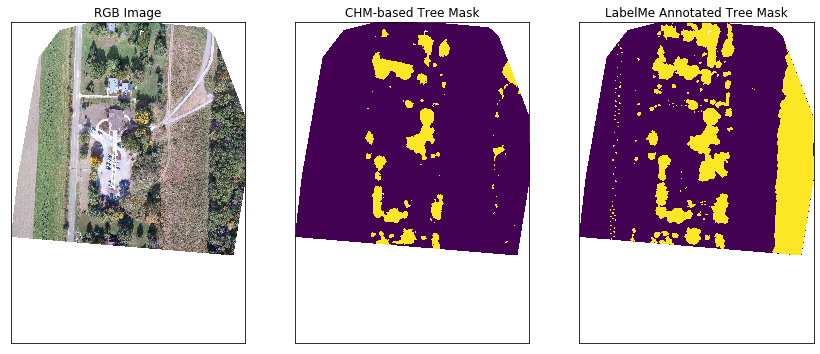

In [75]:
fig, ax = plt.subplots(1, 3, figsize = (12, 5))
ep.plot_rgb(ortho_data, ax = ax[0], title = "RGB Image")
ep.plot_bands(tmask, ax = ax[1], title = "CHM-based Tree Mask", cmap = 'viridis', scale = False, cbar = False)
ep.plot_bands(labelme_mask, ax = ax[2], title = "LabelMe Annotated Tree Mask", cmap = 'viridis', scale = False, cbar = False)
plt.tight_layout()
plt.savefig("../../reports/Figures/labelme/Fig8_labelme_treemask.png", dpi = 300)

In [87]:
def json_annotation_to_array(image_path, json_path, masked = True):
    """Transforms the json annotations of a Geotiff annotated with LabelMe to a numpy array (optionally masked)."""
    with rasterio.open(image_path) as gtif:
        height = gtif.height
        width = gtif.width
        if masked == True:
            data = gtif.read(masked = True)
            data_mask = data.mask
            
    with open(json_path, 'rb') as json_file:
        labelme_json = json.load(json_file)
    
    shapes = []
    for shape in labelme_json['shapes']:
        coord_list = []
        for point in shape['points']:
            coord_list.append((point[0], point[1]))
        shapes.append(({'coordinates': [coord_list], 'type': 'Polygon'}, 255))
    
    labelme_array = rasterio.features.rasterize([(g, 255) for g, v in shapes], 
                                                out_shape = (height, width), 
                                                all_touched=True)
    
    if masked == True:
        labelme_array = np.ma.array(labelme_array)
        labelme_array.mask = data_mask
    
    return labelme_array

In [88]:
json_annotation_to_array(ortho_train_path, "../../data/raw_data/data/ortho_train_labelme_annotated.json")

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=999999,
  dtype=uint8)